In [3]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from dkl_f import rep_sim, get_internals, gauss_DV

from matplotlib.colors import LogNorm, Normalize

from multiprocessing import Pool

/home/lunis/miniconda3/envs/netlogo/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Let's select the parameter space**

In [4]:
# Resolution
res = 40

# Pruning parameters
beta = np.linspace(0.001, 10, res)

# Separation parameter
dist = np.linspace(0, 10, res)

# Set uncertainty on new observations
varc = 10

# Get dimensional d
d_norm = dist[:]/np.sqrt(varc)

# Set number of agents
N = 100

# Where to store values
sv_pth = './b[' + str(beta[0]) + ',' + str(beta[-1]) + ']d[' + str(dist[0]) + ',' + str(dist[-1]) + ']/'

**Print phase space from saved data**

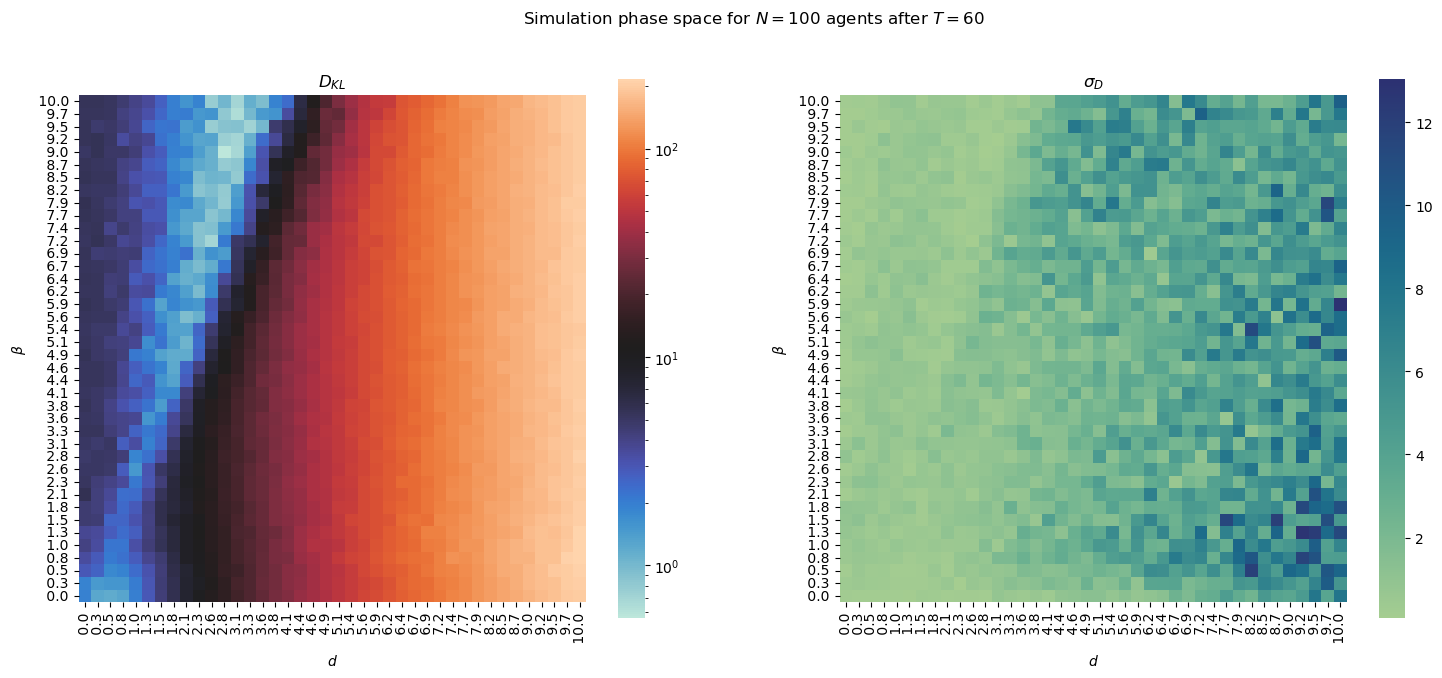

In [5]:
# Load saved arrays
DV = np.load(sv_pth + str(res) + 'DV.npy')
DV_var = np.load(sv_pth + str(res) + 'DV_var.npy')
DV0 = np.load(sv_pth + str(res) + 'DV0.npy')
DV0_var = np.load(sv_pth + str(res) + 'DV0_var.npy')


# Get labels for graphics
b_st = []
for b in beta:

    b_st.append(f'{b: 0,.1f}')

d_st = []
for dis in dist:

    d_st.append(f'{dis: 0,.1f}')

# Print phase space
fig, ax = plt.subplots(1,2, figsize = (18,7))

sns.heatmap(DV, norm = LogNorm(), square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
sns.heatmap(np.sqrt(DV_var), square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

ax[0].set_title('$D_{KL}$', )
ax[1].set_title('$\\sigma_{D}$')

for a in ax:

    a.invert_yaxis()
    #a.invert_xaxis()

    a.set_xlabel('$d$')
    a.set_ylabel('$\\beta$')

fig.suptitle('Simulation phase space for $N = 100$ agents after $T = 60$')

plt.savefig('aaa.png', dpi = 300)
plt.show()

**Let's explore these pixels**

In [ ]:
# Select parameters

# Number of agents
Na = 100
# Pruning parameter
b = 4.
# Initial separation of beliefs
d = 10
# Uncertainty on new observation
var_c = 10

# Variance of initial sampling distributions
vartrue = 1

# Duration
t = 60

# Number of simulations
Ns = 5

# Initialize results array
mus = np.empty((0,t+1,Na))
sigmas = mus

for i in tqdm(range(0,Ns), desc = 'Running multiple simulations' , leave = True):
    mu, sigma, _ = get_internals(N = Na, beta = b,
                    dist = d, var_c = var_c, T = t)
    
    mus = np.concatenate((mus, np.asarray(mu)[np.newaxis,:,:]), axis = 0)
    sigmas = np.concatenate((sigmas, np.asarray(sigma)[np.newaxis,:,:]), axis = 0)

print('Done!')


**Calculate $D_{KL}$ for the new runs**

In [ ]:
# Compute Divergence time series

# Initialize
DVts = np.empty((0,t+1))

# Set bins for discretization
n_bins = int(Na/10)

# Compute
for i, mu in enumerate(mus):
    dv = []
    for j, m in enumerate(mu):

        dv.append(gauss_DV(m, power_law(j, d0 = mus[i,0,:].std(), dist = d), nbins = n_bins))
    
    DVts = np.concatenate((DVts, np.asarray(dv)[np.newaxis,:]), axis = 0)

**Have a LOOK at it!**

In [ ]:
# Show the internal beliefs of agents

fig, axs = plt.subplots(3,1, figsize = (7,15))

for ax in axs:

    ax.grid(True)

    if ax != axs[2]:
        ax.set_xlabel('$t$')
        ax.set_xlim(-0.5,t)

# Plot agent beliefs (Yes, all of them)
for i, mu in enumerate(mus):
    axs[0].plot(mu, 'C' + str(i) + '-', alpha = 0.2)

axs[0].set_ylabel('$\\mu_{i}$')
axs[0].set_title('Agents internal beliefs')

# Compare Divergence values
for i, dv in enumerate(DVts):
    axs[1].plot(dv, '--',  color = 'C' + str(i), label = '$D_{KL}$(' + str(i) + ')')

# Compare gaussian variance estimation
for i, s in enumerate(mus.var(axis = 2)):
    axs[1].plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')

# Compare average agent variances (Kinda useless but it.s here)
#for i, s in enumerate(sigmas.mean(axis = 2)):
#    axs[1].plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')

axs[1].legend()

# Plot histograms for CUMULATIVE initial and final distribution
mu0 = mus[:,0,:].reshape(-1)
mut = mus[:,t,:].reshape(-1)

axs[2].hist(mu0, bins = n_bins*mus.shape[0], alpha = 0.5)
axs[2].hist(mut, bins = n_bins*mus.shape[0], alpha = 0.5)

plt.show()

**See what's happening in each repeat run**

In [ ]:
x = np.linspace(-(d+1)*2,(d+1)*2,150)

fig, ax = plt.subplots(1,Ns, figsize = (Ns*5, 5))

for i, a in enumerate(ax):

    a.hist(mus[i,0,:], bins = n_bins, alpha = 0.5)
    a.hist(mus[i,t,:], bins = n_bins, alpha = 0.5)

    gauss0 = Na*norm.pdf(x, loc = mus[i,0,:].mean(), scale = power_law(0, d0 = mus[i,0,:].std(), dist = d))
    gausst = Na*norm.pdf(x, loc = mus[i,t,:].mean(), scale = power_law(t, d0 = mus[i,0,:].std(), dist = d))

    a.plot(x,gauss0, '-', label = '$t = 0$')
    a.plot(x,gausst, '-', label = '$t = $' + str(t))

ax[0].legend()
print(mus[i,t,:].std())
print(power_law(t, mus[i,0,:].std(), dist = d))
plt.show()

In [ ]:
fig, axs = plt.subplots()

x = np.linspace(0,t, 150)

# Compare average agent variances (Kinda useless but it.s here)
for i, s in enumerate(sigmas.mean(axis = 2)):
    axs.plot(s, '-',  color = 'C' + str(i), label = '$<\\sigma^{2}>($' + str(i) + ')')
    axs.plot(x, power_law(x, d0 = mus[i,0,:].std(), dist = d), color = 'C' + str(i))

**Run simulations for $D_{KL}$**

In [1]:
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns

from tqdm import tqdm
from dkl_f import rep_sim, get_internals, gauss_DV

from multiprocessing import Pool

# Select scan parameters

# Resolution
res = 40

# Pruning parameters
beta = np.linspace(0.001, 10, res)

# Separation parameter
dist = np.linspace(0, 10, res)

# Set uncertainty on new observations
varc = 10

# Get dimensional d
d_norm = dist[:]/np.sqrt(varc)

# Set number of agents
N = 100

# Set simulations duration
T = 60

# Set number of repeat runs
reps = 5

# Where to store values
sv_pth = './b[' + str(beta[0]) + ',' + str(beta[-1]) + ']d[' + str(dist[0]) + ',' + str(dist[-1]) + ']/'

In [2]:
# Prepare multiprocessing

# Pool processing
workers = os.cpu_count() - 6
csize = 6

# Initialize results
DV0 = np.empty((0, len(dist)))
DV0_var = DV0
DV = np.empty((0, len(dist)))
DV_var = DV

for b in tqdm(beta, desc= 'Be patient', leave = False):
    
    # Create iterable function
    def irep_sim(dist : float):

        dv0, dv0_var, dv, dv_var = rep_sim(N = N, beta = b, dist = dist, var_c = varc, reps = reps, T = T)

        return dv0, dv0_var, dv, dv_var
    
    # Initialize run results
    d0 = []
    v0 = []

    d = []
    v = []

    # Launch multiprocessing run
    if __name__=='__main__':
        with Pool(workers) as p:
            ps = p.map(irep_sim, dist, chunksize = csize)

            for p in ps:

                d0.append(p[0])
                v0.append(p[1])

                d.append(p[2])
                v.append(p[3])

    # Assemble results
    DV0 = np.concatenate((DV0, np.asarray(d0)[np.newaxis, :]), axis = 0)
    DV0_var = np.concatenate((DV0_var, np.asarray(v0)[np.newaxis, :]), axis = 0)

    DV = np.concatenate((DV, np.asarray(d)[np.newaxis, :]), axis = 0)
    DV_var = np.concatenate((DV_var, np.asarray(v)[np.newaxis, :]), axis = 0)

# Save results to local
os.makedirs(sv_pth, exist_ok = True)
np.save(sv_pth + str(res) + 'DV0.npy', DV0)
np.save(sv_pth + str(res) + 'DV0_var.npy', DV0_var)
np.save(sv_pth + str(res) + 'DV.npy', DV)
np.save(sv_pth + str(res) + 'DV_var.npy', DV_var)

Be patient:  82%|████████▎ | 33/40 [28:38<05:26, 46.61s/it]Aug 09, 2025 2:26:41 PM java.util.prefs.FileSystemPreferences syncWorld
